# Methodology

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import storage

project_id = "sharp-matter-449521-u2"
!gcloud config set project {project_id}

Updated property [core/project].


In [3]:
!wget -P /usr/lib/spark/jars/ https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar

--2025-03-24 04:26:53--  https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 172.217.214.207, 142.250.152.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40713341 (39M) [application/java-archive]
Saving to: ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’

gcs-connector-hadoo 100%[===================>]  38.83M   194MB/s    in 0.2s    

2025-03-24 04:26:53 (194 MB/s) - ‘/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar’ saved [40713341/40713341]



In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.jars", "/usr/lib/spark/jars/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.gs.auth.service.account.enable", "true") \
    .getOrCreate()

In [7]:
spark

In [8]:
df_reviews = spark.read.parquet('gs://final_dataset_dat490/dat490_final_dataset_cleaned.parquet', headers=True, inferSchema=True)

In [9]:
df_reviews.columns

['gmap_id',
 'customer_name',
 'rating',
 'reviews',
 'time',
 'avg_rating',
 'category',
 'latitude',
 'longitude',
 'business_name',
 'num_of_reviews',
 'state',
 'standard_category',
 'Monday',
 'Tuesday',
 'Wednesday',
 'Thursday',
 'Friday',
 'Saturday',
 'Sunday',
 'timestamp',
 'week',
 'month',
 'year',
 'time_seconds']

## VADER

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon")

# Initializing VADER
sia = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    if text:
        return float(sia.polarity_scores(text)["compound"])
    else:
        return 0.0

vader_udf = udf(vader_sentiment, FloatType())

df_sentiment = df_reviews.withColumn("sentiment_score", vader_udf("reviews"))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [11]:
from pyspark.sql.functions import when

df_sentiment = df_sentiment.withColumn(
    "sentiment_label",
    when(df_sentiment["sentiment_score"] > 0.05, "Positive")
    .when(df_sentiment["sentiment_score"] < -0.05, "Negative")
    .otherwise("Neutral")
)

In [13]:
df_sentiment.select("reviews", "sentiment_score", "sentiment_label").show(10)

+--------------------+---------------+---------------+
|             reviews|sentiment_score|sentiment_label|
+--------------------+---------------+---------------+
|The pizza, steak ...|         0.6114|       Positive|
|Great way to get ...|         0.6249|       Positive|
|Went there for a ...|         0.7392|       Positive|
|Friendly and know...|         0.4939|       Positive|
|My personal choic...|         0.8308|       Positive|
|This store has be...|        -0.6324|       Negative|
|I am disappointed...|          0.975|       Positive|
|AUAF oversee a va...|         0.9042|       Positive|
|Great neighborhoo...|         0.6249|       Positive|
|This is place is ...|         0.8807|       Positive|
+--------------------+---------------+---------------+
only showing top 10 rows



In [14]:
from pyspark.sql.functions import approx_count_distinct

df_sentiment_counts = df_sentiment.groupBy("sentiment_label").agg(approx_count_distinct("gmap_id").alias("approx_count"))

In [15]:
from pyspark.sql.functions import approx_count_distinct

df_sentiment.groupBy("sentiment_label").agg(approx_count_distinct("gmap_id").alias("approx_count")).show()

+---------------+------------+
|sentiment_label|approx_count|
+---------------+------------+
|       Positive|     2647752|
|        Neutral|       91804|
|       Negative|      227790|
+---------------+------------+



In [16]:
from pyspark.sql.functions import col, round

df_percentages = df_sentiment_counts.withColumn(
    "percentage", round((col("approx_count") / 2884722) * 100, 2)
)

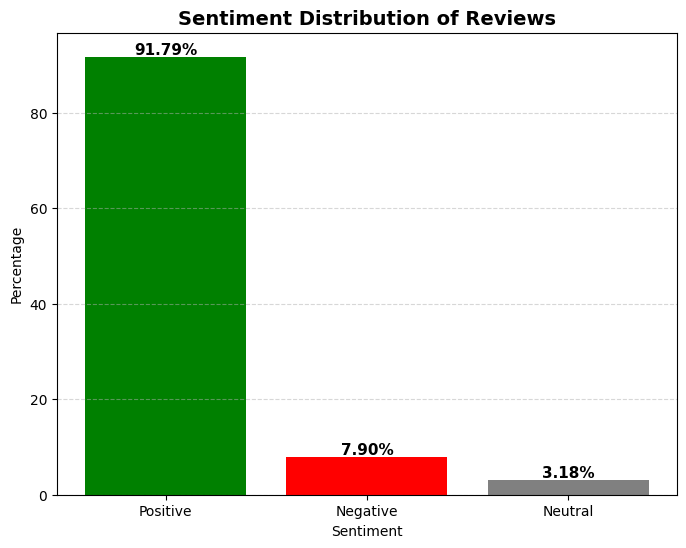

In [17]:
df_percentages_pd = df_percentages.toPandas()

import matplotlib.pyplot as plt

df_percentages_pd = df_percentages_pd.sort_values("percentage", ascending=False)

plt.figure(figsize=(8, 6))
bars = plt.bar(df_percentages_pd["sentiment_label"], df_percentages_pd["percentage"], color=["green", "red", "gray"])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{height:.2f}%",
        ha="center",
        fontsize=11,
        fontweight="bold"
    )

plt.title("Sentiment Distribution of Reviews", fontsize=14, fontweight="bold")
plt.ylabel("Percentage")
plt.xlabel("Sentiment")
plt.ylim(0, df_percentages_pd["percentage"].max() + 5)

plt.show()


## TextBlob

In [18]:
from pyspark.sql.functions import col, when, regexp_replace
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

def get_textblob_sentiment(text):
    if text is not None and isinstance(text, str):
        blob = TextBlob(text)
        return float(blob.sentiment.polarity), float(blob.sentiment.subjectivity)
    else:
        return 0.0, 0.0

schema = StructType([
    StructField("polarity", DoubleType(), True),
    StructField("subjectivity", DoubleType(), True)
])

sentiment_udf = udf(get_textblob_sentiment, schema)

df_reviews = df_reviews.withColumn("sentiment", sentiment_udf("reviews"))
df_reviews = df_reviews.withColumn("polarity", col("sentiment.polarity"))
df_reviews = df_reviews.withColumn("subjectivity", col("sentiment.subjectivity"))

In [19]:
from pyspark.sql.functions import when

# Putting all the reviews into 3 categories based on their polarity
df_reviews = df_reviews.withColumn(
    "sentiment_label",
    when(col("polarity") <= -0.2, "Negative").
    when(col("polarity") <= 0.2, "Neutral").
    otherwise("Positive")
)

In [20]:
df_reviews.select('reviews', 'polarity', 'sentiment_label').show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+---------------+
|reviews                                                                                                                                                                                                                

In [21]:
sentiment_label_count = df_reviews.groupby('sentiment_label').count()

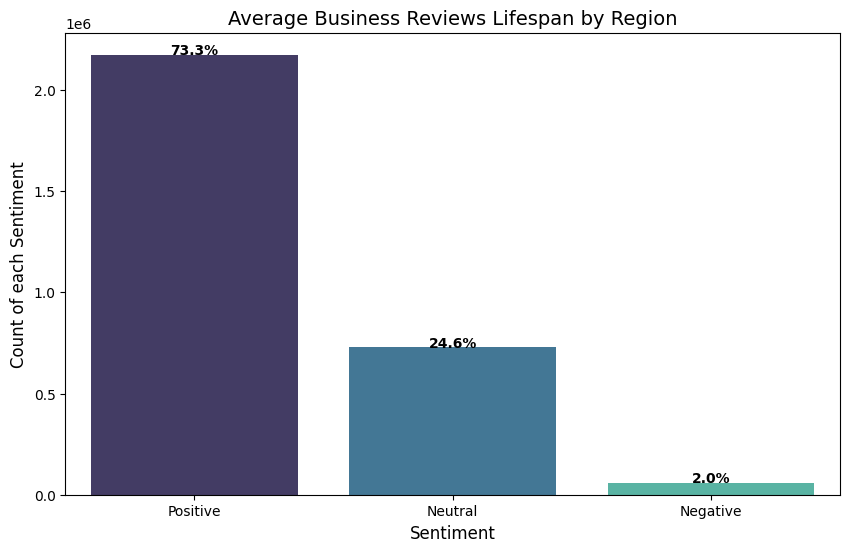

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment_label_count_pd = sentiment_label_count.toPandas()

sentiment_label_count_pd["percentage"] = (sentiment_label_count_pd["count"] /
                                             sentiment_label_count_pd["count"].sum()) * 100

plt.figure(figsize=(10,6))
ax = sns.barplot(data=sentiment_label_count_pd, x="sentiment_label", y="count", hue="sentiment_label", palette="mako")

for p, perc in zip(ax.patches, sentiment_label_count_pd["percentage"]):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.1, f'{perc:.1f}%',
            ha="center", fontsize=10, fontweight="bold")

plt.title("Average Business Reviews Lifespan by Region", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count of each Sentiment", fontsize=12)

plt.show()